# Connecting to Database

In [ ]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.3.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop2.tgz
!tar xf spark-3.3.0-bin-hadoop2.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 261 kB in 3s (82.4 kB/s)
Reading package li

In [ ]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2022-10-01 23:40:06--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar.4’

postgresql-42.2.9.j 100%[===================>] 892.61K  5.72MB/s    in 0.2s    

2022-10-01 23:40:07 (5.72 MB/s) - ‘postgresql-42.2.9.jar.4’ saved [914037/914037]



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [ ]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url="https://group-project-data-bucket.s3.amazonaws.com/clean_salary_data.csv"
spark.sparkContext.addFile(url)
salary_data = spark.read.csv(SparkFiles.get("clean_salary_data.csv"), sep=",", header=True, inferSchema=True)

# Show Dataset
salary_data.show()

+---+-------------------+----------+-----+--------------------+-----------------------+-----------------+--------------+----------+---------------+-------+---------+--------------+----------------+----------------+----------+------------+----------+----------+----------------+----------+-------------+-------------+-----+
|_c0|          timestamp|   company|level|               title|totalyearlycompensation|yearsofexperience|yearsatcompany|basesalary|stockgrantvalue|  bonus|rowNumber|Masters_Degree|Bachelors_Degree|Doctorate_Degree|Highschool|Some_College|Race_Asian|Race_White|Race_Two_Or_More|Race_Black|Race_Hispanic|         city|state|
+---+-------------------+----------+-----+--------------------+-----------------------+-----------------+--------------+----------+---------------+-------+---------+--------------+----------------+----------------+----------+------------+----------+----------+----------------+----------+-------------+-------------+-----+
|  0|2017-06-07 11:33:00|    Or

# Preprocessing

## Developing Salary Dataframe for prediction model

In [ ]:
#Import dependancies
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
salary_df = salary_data.toPandas()
salary_df.head() 

,_c0,timestamp,company,level,title,totalyearlycompensation,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,city,state
0,0,2017-06-07 11:33:00,Oracle,L3,Product Manager,127000,1.5,1.5,107000,20000.0,...,0,0,0,0,0,0,0,0,Redwood City,CA
1,1,2017-06-10 17:11:00,eBay,SE 2,Software Engineer,100000,5.0,3.0,0,0.0,...,0,0,0,0,0,0,0,0,San Francisco,CA
2,2,2017-06-11 14:53:00,Amazon,L7,Product Manager,310000,8.0,0.0,155000,0.0,...,0,0,0,0,0,0,0,0,Seattle,WA
3,3,2017-06-17 00:23:00,Apple,M1,Software Engineering Manager,372000,7.0,5.0,157000,180000.0,...,0,0,0,0,0,0,0,0,Sunnyvale,CA
4,4,2017-06-20 10:58:00,Microsoft,60,Software Engineer,157000,5.0,3.0,0,0.0,...,0,0,0,0,0,0,0,0,Mountain View,CA


In [ ]:
# Information about the dataframe
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52746 entries, 0 to 52745
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   _c0                      52746 non-null  int32         
 1   timestamp                52746 non-null  datetime64[ns]
 2   company                  52746 non-null  object        
 3   level                    52746 non-null  object        
 4   title                    52746 non-null  object        
 5   totalyearlycompensation  52746 non-null  int32         
 6   yearsofexperience        52746 non-null  float64       
 7   yearsatcompany           52746 non-null  float64       
 8   basesalary               52746 non-null  int32         
 9   stockgrantvalue          52746 non-null  float64       
 10  bonus                    52746 non-null  float64       
 11  rowNumber                52746 non-null  int32         
 12  Masters_Degree           52746 n

In [ ]:
# Create dataframe with only columns relevant for the prediction model
ml_df = salary_df[['timestamp','company', 'title','totalyearlycompensation', 'yearsofexperience','basesalary','stockgrantvalue','bonus']]
ml_df.head(5)

,timestamp,company,title,totalyearlycompensation,yearsofexperience,basesalary,stockgrantvalue,bonus
0,2017-06-07 11:33:00,Oracle,Product Manager,127000,1.5,107000,20000.0,10000.0
1,2017-06-10 17:11:00,eBay,Software Engineer,100000,5.0,0,0.0,0.0
2,2017-06-11 14:53:00,Amazon,Product Manager,310000,8.0,155000,0.0,0.0
3,2017-06-17 00:23:00,Apple,Software Engineering Manager,372000,7.0,157000,180000.0,35000.0
4,2017-06-20 10:58:00,Microsoft,Software Engineer,157000,5.0,0,0.0,0.0


In [ ]:
# Look for missing values
ml_df.isna().sum()

timestamp                  0
company                    0
title                      0
totalyearlycompensation    0
yearsofexperience          0
basesalary                 0
stockgrantvalue            0
bonus                      0
dtype: int64

In [ ]:
# Add a Year  and quarter column and from timestamp column
ml_df['yearposted'] = pd.DatetimeIndex(ml_df['timestamp']).year
ml_df['yearquarter'] = ml_df['timestamp'].dt.to_period("Q").astype('str')
ml_df = ml_df.drop(['timestamp'], axis = 1)
ml_df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,company,title,totalyearlycompensation,yearsofexperience,basesalary,stockgrantvalue,bonus,yearposted,yearquarter
0,Oracle,Product Manager,127000,1.5,107000,20000.0,10000.0,2017,2017Q2
1,eBay,Software Engineer,100000,5.0,0,0.0,0.0,2017,2017Q2
2,Amazon,Product Manager,310000,8.0,155000,0.0,0.0,2017,2017Q2
3,Apple,Software Engineering Manager,372000,7.0,157000,180000.0,35000.0,2017,2017Q2
4,Microsoft,Software Engineer,157000,5.0,0,0.0,0.0,2017,2017Q2


## Remove rows where base salary equals $0

In [ ]:
ml_df = ml_df.loc[ml_df['basesalary'] > 0]

In [ ]:
ml_df.head()

,company,title,totalyearlycompensation,yearsofexperience,basesalary,stockgrantvalue,bonus,yearposted,yearquarter
0,Oracle,Product Manager,127000,1.5,107000,20000.0,10000.0,2017,2017Q2
2,Amazon,Product Manager,310000,8.0,155000,0.0,0.0,2017,2017Q2
3,Apple,Software Engineering Manager,372000,7.0,157000,180000.0,35000.0,2017,2017Q2
6,Microsoft,Software Engineering Manager,300000,15.0,180000,65000.0,55000.0,2017,2017Q2
7,Microsoft,Software Engineer,156000,4.0,135000,8000.0,13000.0,2017,2017Q2


## Cleaning company and title columns

### Company Column

In [ ]:
ml_df['company']

0            Oracle
2            Amazon
3             Apple
6         Microsoft
7         Microsoft
            ...    
52741        Google
52742     Microsoft
52743          MSFT
52744    Salesforce
52745         apple
Name: company, Length: 50690, dtype: object

As noted, there are different spellings for each company. We will try our best to clean the company column

In [ ]:
# Converts all lowercase characters into uppercase characters
ml_df['company'] = ml_df['company'].str.strip().str.upper()
ml_df['company']

0            ORACLE
2            AMAZON
3             APPLE
6         MICROSOFT
7         MICROSOFT
            ...    
52741        GOOGLE
52742     MICROSOFT
52743          MSFT
52744    SALESFORCE
52745         APPLE
Name: company, Length: 50690, dtype: object

In [ ]:
# Remove any extra spaces
ml_df['company']= ml_df['company'].replace(r'\s+', ' ', regex=True)
ml_df['company']

0            ORACLE
2            AMAZON
3             APPLE
6         MICROSOFT
7         MICROSOFT
            ...    
52741        GOOGLE
52742     MICROSOFT
52743          MSFT
52744    SALESFORCE
52745         APPLE
Name: company, Length: 50690, dtype: object

In [ ]:
ml_df['company'] = ml_df['company'].str.replace(' LLC', '').str.replace('.ORG', '').str.replace(' LTD', '').str.replace(' CORPORATION', '').str.replace(' INC', '')
ml_df['company'] = ml_df['company'].str.replace(' MEDIA', '').str.replace(' GROUP', '').str.replace(' TECHNOLOGY', '').str.replace(' TECHNOLOGIES', '').str.strip()
ml_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,company,title,totalyearlycompensation,yearsofexperience,basesalary,stockgrantvalue,bonus,yearposted,yearquarter
0,ORACLE,Product Manager,127000,1.5,107000,20000.0,10000.0,2017,2017Q2
2,AMAZON,Product Manager,310000,8.0,155000,0.0,0.0,2017,2017Q2
3,APPLE,Software Engineering Manager,372000,7.0,157000,180000.0,35000.0,2017,2017Q2
6,MICROSOFT,Software Engineering Manager,300000,15.0,180000,65000.0,55000.0,2017,2017Q2
7,MICROSOFT,Software Engineer,156000,4.0,135000,8000.0,13000.0,2017,2017Q2


In [ ]:
# Check how many unique values are in the company column
ml_df['company'].nunique()

998

Looking at the raw data file there are examples wher the same company is spelled in different ways. For example, "AMAZON", shows as "AMZON", "AWS", "AMAZON WEB SERVICES". 

In [ ]:
# Clean company names
def clean_company_names(name):
     try: 
         if name.startswith('AMAZON'): final_name = 'AMAZON'
         elif name.startswith('AMZON'): final_name = 'AMAZON'
         elif name.startswith('AWS'): final_name = 'AMAZON'
         elif name.startswith('AMAZON.COM'): final_name = 'AMAZON'
         elif name.startswith('AKAMI'): final_name = 'AKAMI'
         elif name.startswith('BAIN'): final_name = 'BAIN & COMPANY'
         elif name.startswith('APPLE'): final_name = 'APPLE'
         elif name.startswith('ARISTA'): final_name = 'ARISTA'
         elif name.startswith('ARUBA'): final_name = 'ARUBA'
         elif name.startswith('BLOOMBERG'): final_name = 'BLOOMBERG'
         elif name.startswith('BOOKING'): final_name = 'BOOKING.COM'
         elif name.startswith('BOSCH'): final_name = 'BOSCH'
         elif name.startswith('CACI'): final_name = 'CACI'
         elif name.startswith('CADENCE'): final_name = 'CADENCE'
         elif name.startswith('CGI'): final_name = 'CGI'
         elif name.startswith('CISCO'): final_name = 'CISCO'   
         elif name.startswith('COGNIZANT'): final_name = 'COGNIZANT'
         elif name.startswith('COSTCO'): final_name = 'COSTCO'
         elif name.startswith('COUPA'): final_name = 'COUPA'
         elif name.startswith('DELL'): final_name = 'DELL'
         elif name.startswith('DELOITTE'): final_name = 'DELOITTE'
         elif name.startswith('DISCOVER'): final_name = 'DISCOVER'
         elif name.startswith('DISH'): final_name = 'DISH'
         elif name.startswith('DISNEY'): final_name = 'DISNEY'   
         elif name.startswith('EPAM'): final_name = 'EPAM'
         elif name.startswith('ERNST'): final_name = 'ERNST & YOUNG'
         elif name.startswith('EXPEDIA'): final_name = 'EXPEDIA'
         elif name.startswith('FORD'): final_name = 'FORD'
         elif name.startswith('GE'): final_name = 'GE'
         elif name.startswith('GENERAL ELECTRIC'): final_name = 'EXPEDIA'
         elif name.startswith('GOOGLE'): final_name = 'GOOGLE'
         elif name.startswith('GUIDEWARE'): final_name = 'GUIDEWARE'
         elif name.startswith('HERE'): final_name = 'HERE'
         elif name.startswith('INTUITIVE'): final_name = 'INTUITIVE'
         elif name.startswith('JANE STREET'): final_name = 'JANE STREET'
         elif name.startswith('JOHNSON'): final_name = 'JOHNSON'
         elif name.startswith('JPMORGAN'): final_name = 'JP MORGAN'
         elif name.startswith('JP'): final_name = 'JP MORGAN'
         elif name.startswith('JUNIPER'): final_name = 'JUNIPER'
         elif name.startswith('L3HARRIS'): final_name = 'L3HARRIS'
         elif name.startswith('LIBERTY MUTUAL'): final_name = 'LIBERTY MUTUAL'
         elif name.startswith('MACY'): final_name = "MACY'S"
         elif name.startswith('MCKINSEY'): final_name = 'MCKINSEY & COMPANY'
         elif name.startswith('MICROCHIP'): final_name = 'MICROCHIP'
         elif name.startswith('MICRON'): final_name = 'MICRON'
         elif name.startswith('MICROSOFT'): final_name = 'MICROSOFT'
         elif name.startswith('MSFT'): final_name = 'MICROSOFT'
         elif name.startswith("MOODY'S"): final_name = "MOODY'S"                
         elif name.startswith('MOTOROLA'): final_name = 'MOTOROLA'
         elif name.startswith('NUANCE'): final_name = 'NUANCE'
         elif name.startswith('NXP'): final_name = 'NXP'
         elif name.startswith('PANASONIC'): final_name = 'PANASONIC'
         elif name.startswith('PROCORE'): final_name = 'PROCORE'
         elif name.startswith('QUALCOMM'): final_name = 'QUALCOMM'
         elif name.startswith('RAYTHEON'): final_name = 'RAYTHEON'
         elif name.startswith('SAMSUNG'): final_name = 'SAMSUNG'
         elif name.startswith('SAP'): final_name = 'SAP'
         elif name.startswith('SAS'): final_name = 'SAS'
         elif name.startswith('SONY'): final_name = 'SONY'          
         elif name.startswith('TOYOTA'): final_name = 'TOYOTA'
         elif name.startswith('VERIZON'): final_name = 'VERIZON'
         elif name.startswith('VISA'): final_name = 'VISA'      
         elif name.startswith('WALMART'): final_name = 'WALMART'
         elif name.startswith('WILPRO'): final_name = 'WILPRO'
         elif name.startswith('ZILLOW'): final_name = 'ZILLOW'
         elif name.startswith('ZS ASSOCIATES'): final_name = 'ZS'    
         else: final_name = name
     except:
         final_name = name
     return final_name

ml_df['company'] = ml_df['company'].apply(lambda name: clean_company_names(name))
ml_df.head()

,company,title,totalyearlycompensation,yearsofexperience,basesalary,stockgrantvalue,bonus,yearposted,yearquarter
0,ORACLE,Product Manager,127000,1.5,107000,20000.0,10000.0,2017,2017Q2
2,AMAZON,Product Manager,310000,8.0,155000,0.0,0.0,2017,2017Q2
3,APPLE,Software Engineering Manager,372000,7.0,157000,180000.0,35000.0,2017,2017Q2
6,MICROSOFT,Software Engineering Manager,300000,15.0,180000,65000.0,55000.0,2017,2017Q2
7,MICROSOFT,Software Engineer,156000,4.0,135000,8000.0,13000.0,2017,2017Q2


In [ ]:
# Check how many unique values are in the company column
ml_df['company'].nunique()

927

### Job Title Column

In [ ]:
ml_df['title']

0                     Product Manager
2                     Product Manager
3        Software Engineering Manager
6        Software Engineering Manager
7                   Software Engineer
                     ...             
52741               Software Engineer
52742               Software Engineer
52743               Software Engineer
52744               Software Engineer
52745               Software Engineer
Name: title, Length: 50690, dtype: object

In [ ]:
# Filter to only jobs related to Data Scientist and Analyst
ml_df = ml_df[(ml_df.title == "Data Scientist") | (ml_df.title == 'Business Analyst')]
ml_df.head()


,company,title,totalyearlycompensation,yearsofexperience,basesalary,stockgrantvalue,bonus,yearposted,yearquarter
399,LINKEDIN,Data Scientist,233000,4.0,162000,220000.0,10000.0,2018,2018Q2
420,MICROSOFT,Data Scientist,218000,11.0,165000,28000.0,23000.0,2018,2018Q2
432,TWITTER,Data Scientist,500000,4.0,200000,280000.0,20000.0,2018,2018Q2
466,FACEBOOK,Data Scientist,370000,8.0,190000,140000.0,40000.0,2018,2018Q2
470,AMAZON,Data Scientist,200000,3.0,150000,105000.0,81000.0,2018,2018Q2


### Export dataframe to excel file

In [ ]:
# Check current information
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2858 entries, 399 to 52727
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  2858 non-null   object 
 1   title                    2858 non-null   object 
 2   totalyearlycompensation  2858 non-null   int32  
 3   yearsofexperience        2858 non-null   float64
 4   basesalary               2858 non-null   int32  
 5   stockgrantvalue          2858 non-null   float64
 6   bonus                    2858 non-null   float64
 7   yearposted               2858 non-null   int64  
 8   yearquarter              2858 non-null   object 
dtypes: float64(3), int32(2), int64(1), object(3)
memory usage: 201.0+ KB


In [ ]:
# Create the path to your file directory
filepath = path('/Users/mariasevillano/Documents/OneDrive/Data Visualization Bootcamp/Final_Project/GroupProject/Resources/ml_metadata.csv')
# Save Dataframe tp csv file
ml_df.to_csv(filepath, index=False)

NameError: ignored

## Develop quick insights

### Scatter Plot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


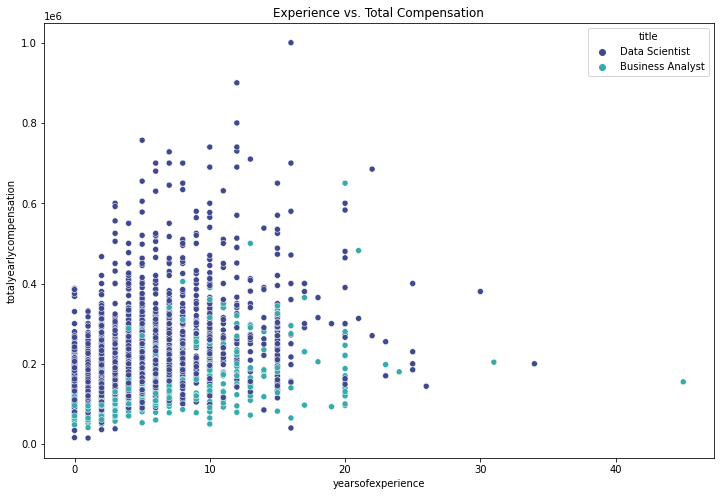

In [37]:
# Years of Experience
plt.figure(figsize=(12,8))
sns.scatterplot('yearsofexperience','totalyearlycompensation', data = ml_df, hue = "title", palette='mako').set(title='Experience vs. Total Compensation')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


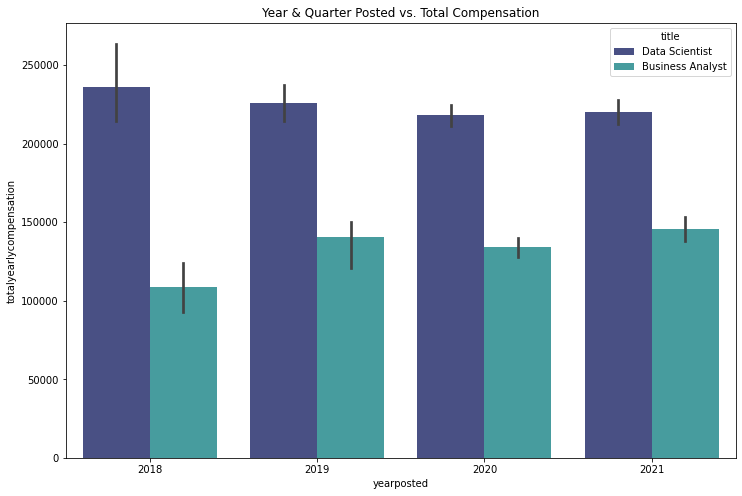

In [43]:
# Year Posted
plt.figure(figsize=(12,8))
sns.barplot('yearposted','totalyearlycompensation', data = ml_df, hue = "title", palette='mako').set(title='Year Posted vs. Total Compensation')
plt.show()